In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

### bullshit

In [57]:
# a = set({1,4,6,7})
#b = set({7, 8, 9})
# set({}).union(set({20}))
"Policy" in tmp.columns

True

In [69]:
[["a","b"]]*4
tmp.shape[0]

6

In [2]:
tmp = pd.read_csv("data/lstm_rl_curr_multi1/eval/results.csv")

In [16]:
tmp

,env,succ,coll,time,std_time,rew,std_rew,disc_freq,danger_d_min,std_danger
0,bl-cr,0.42,0.10,16.500000,3.413035,0.050479,0.122116,0.033126,0.099790,0.063301
1,bl-sq,0.44,0.04,13.681818,3.957287,0.100697,0.150815,0.020546,0.111208,0.067485
2,dn-cr,0.50,0.40,15.600000,5.187967,0.008419,0.181133,0.158905,0.102166,0.060098
3,dn-sq,0.48,0.40,13.000000,2.891258,-0.008037,0.203064,0.236301,0.096024,0.060972
4,lg-cr,0.54,0.18,19.870370,5.473577,0.000331,0.120705,0.121433,0.108968,0.062399
5,lg-sq,0.46,0.38,19.521739,4.312465,-0.050496,0.146234,0.213649,0.101726,0.066679


### Result groupings

In [2]:


default_paths = [
    "output_lstm",
    "output_cadrl_new",
    "output_sarl_bl_vis"
]
curr_paths = [
    "lstm_rl_curr1",
    "cadrl_curr1",
    "sarl_curr1"
]
div_paths = [
    "lstm_rl_div1",
    "cadrl_div1",
    "output_multi_sarl"
]
curr_div_paths = [ 
    "lstm_rl_curr_multi1",
    "cadrl_curr_multi1",
    "output_transfer_sarl"
]
#=====
paths_by_training = {
    "default": default_paths,
    "curr": curr_paths,
    "div": div_paths,
    "curr_div": curr_div_paths
}

#==============================
#==============================

lstm_paths = [
    "output_lstm",
    "lstm_rl_curr1",
    "lstm_rl_div1",
    "lstm_rl_curr_multi1"
]
cadrl_paths = [
    "output_cadrl_new",
    "cadrl_curr1",
    "cadrl_div1",
    "cadrl_curr_multi1"   
]
sarl_paths = [
    "output_sarl_bl_vis",
    "sarl_curr1",
    "output_multi_sarl",
    "output_transfer_sarl"
]    

#=====
paths_by_model = {
    "lstm_paths": lstm_paths,
    "cadrl_paths": cadrl_paths,
    "sarl_paths": sarl_paths
}
    


In [3]:
def parse_policy(s):
    policies = [
        "lstm",
        "cadrl",
        "sarl",
        "orca"
    ]
    
    for policy in policies:
        if policy in s:
            return policy

    raise RuntimeError(f"Policy must be one of ['lstm', 'cadrl', 'sarl', 'orca']. Given string: {s}")

def parse_methods(s):
    methods_dict = {
        "div": set({"div"}),
        "multi": set({"div"}),
        "curr": set({"curr"}),
        "trans": set({"curr"}),
        "transfer": set({"curr", "div"})
    }
    
    parsed_methods = set({})
    
    for method in methods_dict.keys():
        if method in s:
            #print(f"method_key: {method}\nmethod_val: {methods_dict[method]}")
            parsed_methods = parsed_methods.union(methods_dict[method])
    
    return tuple(sorted(parsed_methods))
    

In [4]:
def csv_from_title(s):
    return pd.read_csv(f"data/{s}/eval/results.csv")

def add_policy_col(df, s):
    policy = parse_policy(s)
    df.insert(0, "Policy", policy)
    return df

def add_method_col(df, s):
    methods = parse_methods(s)
    idx = 1 if "Policy" in df.columns else 0
    df.insert(idx, "Methods", None)
    df["Methods"] = (methods,)*df.shape[0]
    return df

### Take avg of test results

In [5]:
def avg_results(df, envs=None):
    """
    Average the results from one policy-method experiment.
    
    Arguments:
    - df: results (df)
    - envs: list of envs to be included (str[]) 
    
    Returns:
    - df_view: series of averaged values, with columns ["Policy", "Methods", "env"] removed (pd.Series)
    """
    # Assert looking at only one policy
    assert df['Policy'].unique().size == 1
    
    # Assert looking at only one method combination. Here we are joining together 
    # the list of methods used so that the combo can be easily interpreted as a single value.
    assert df['Methods'].apply(lambda x: "".join(x)).unique().size == 1
    
    
    
    
    if envs:
        assert isinstance(envs, list)
        # select rows with these envs
        df_view = df.loc[df['env'].isin(envs)] # TODO: CHANGE
        # .loc[row_indexer,col_indexer]
        #pass
    else:
        df_view = df
    
    # print("Before squaring")
    # display(df_view)#[['std_time', 'std_rew', 'std_danger']])
    df_view[['std_time', 'std_rew', 'std_danger']] = df_view[['std_time', 'std_rew', 'std_danger']].apply(lambda x: np.power(x, 2), axis=1)
    # print("After squaring")
    # display(df_view)#[['std_time', 'std_rew', 'std_danger']])
    
    df_view = df_view.drop('env', axis=1) 
    
    # XXX: I think this removes 'Method' column
    df_view = df_view.mean()
    # TODO: SHOULD WE ADD BACK CURRMETHOD HERE, OR IN A CALLER FUNCTION? -- that's what i'm doing for now
    #currmethod = df['Methods'][0]
    # print(currmethod)
    
    # to get the mean of std, you have to take the mean of variance (std^2), then take sqrt
    df_view[['std_time', 'std_rew', 'std_danger']] = df_view[['std_time', 'std_rew', 'std_danger']].apply(np.sqrt)
    
    #df_view['Methods'] = currmethod
    
    return df_view
    

In [93]:
res = avg_results(results_by_training['default'][0])

Before squaring


,Policy,Methods,env,succ,coll,time,std_time,rew,std_rew,disc_freq,danger_d_min,std_danger
0,lstm,(),bl-cr,0.80,0.08,11.337500,648.046370,0.223636,6.961732e-07,0.056086,0.099885,9.218909e-11
1,lstm,(),bl-sq,0.78,0.06,12.435897,14331.517103,0.199378,4.459424e-07,0.060888,0.105003,2.626668e-10
2,lstm,(),dn-cr,0.64,0.32,11.781250,10950.054986,0.090873,8.373711e-06,0.230769,0.089038,1.322952e-10
3,lstm,(),dn-sq,0.50,0.48,13.870000,982136.846339,-0.022762,4.623619e-06,0.305238,0.093437,2.032278e-10
4,lstm,(),lg-cr,0.58,0.30,18.232759,104167.000137,0.010398,4.164132e-07,0.099371,0.090209,1.750393e-10
5,lstm,(),lg-sq,0.50,0.40,19.110000,440362.581873,-0.034977,2.119195e-07,0.185767,0.102953,1.243508e-10


After squaring


,Policy,Methods,env,succ,coll,time,std_time,rew,std_rew,disc_freq,danger_d_min,std_danger
0,lstm,(),bl-cr,0.80,0.08,11.337500,4.199641e+05,0.223636,4.846572e-13,0.056086,0.099885,8.498828e-21
1,lstm,(),bl-sq,0.78,0.06,12.435897,2.053924e+08,0.199378,1.988647e-13,0.060888,0.105003,6.899384e-20
2,lstm,(),dn-cr,0.64,0.32,11.781250,1.199037e+08,0.090873,7.011903e-11,0.230769,0.089038,1.750201e-20
3,lstm,(),dn-sq,0.50,0.48,13.870000,9.645928e+11,-0.022762,2.137786e-11,0.305238,0.093437,4.130156e-20
4,lstm,(),lg-cr,0.58,0.30,18.232759,1.085076e+10,0.010398,1.734000e-13,0.099371,0.090209,3.063877e-20
5,lstm,(),lg-sq,0.50,0.40,19.110000,1.939192e+11,-0.034977,4.490989e-14,0.185767,0.102953,1.546312e-20


In [96]:
type(res)

pandas.core.series.Series

### Collect result dfs

In [6]:
results_by_training = {}
avgs_tmp = []

# default, curr, div, div_curr
for train_method in paths_by_training:
    results_by_training[train_method] = []
    
    #avg = None
    # lstm, cadrl, sarl
    for s in paths_by_training[train_method]:
        #print(s)
        df = csv_from_title(s)
        add_method_col(df, s)
        add_policy_col(df, s)
        results_by_training[train_method].append(df)
        
        avg = avg_results(df, envs=["dn-cr", "dn-sq", "lg-cr", "lg-sq"])
        # average vals for current policy-method
        #print(f"p_m:\n{p_m}\n")
        #print(f"avg:\n{avg}\n")
        p_m = pd.Series([parse_policy(s), parse_methods(s)])
        
        #print(f"concat:\n{pd.concat([p_m, avg])}")
        avgs_tmp.append(pd.concat([p_m, avg]))
        #print()
    
    print()
    
avgs_by_training = pd.DataFrame(avgs_tmp).rename(columns = {0: "Policy", 1: "Methods"})#, columns = ['Policy', 'Methods', 'succ', 'coll', 'time', 'std_time', 'rew', 'std_rew', 'disc_freq', 'danger_d_min', 'std_danger'])


/home/adam/.local/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [77]:
# show results (warning: big output)
results_by_training['default'][0]

,Policy,Methods,env,succ,coll,time,std_time,rew,std_rew,disc_freq,danger_d_min,std_danger
0,lstm,(),bl-cr,0.80,0.08,11.337500,2.246212,0.223636,0.169957,0.056086,0.099885,0.055665
1,lstm,(),bl-sq,0.78,0.06,12.435897,3.307779,0.199378,0.160753,0.060888,0.105003,0.063449
2,lstm,(),dn-cr,0.64,0.32,11.781250,3.198358,0.090873,0.231934,0.230769,0.089038,0.058236
3,lstm,(),dn-sq,0.50,0.48,13.870000,5.610758,-0.022762,0.215339,0.305238,0.093437,0.061447
4,lstm,(),lg-cr,0.58,0.30,18.232759,4.238540,0.010398,0.159382,0.099371,0.090209,0.060310
5,lstm,(),lg-sq,0.50,0.40,19.110000,5.075470,-0.034977,0.146478,0.185767,0.102953,0.057787


In [78]:
tmp = pd.read_csv("data/lstm_rl_curr_multi1/eval/results.csv")
add_method_col(tmp, "data/lstm_rl_curr_multi1/eval/results.csv")
add_policy_col(tmp, "data/lstm_rl_curr_multi1/eval/results.csv")

,Policy,Methods,env,succ,coll,time,std_time,rew,std_rew,disc_freq,danger_d_min,std_danger
0,lstm,"(curr, div)",bl-cr,0.42,0.10,16.500000,3.413035,0.050479,0.122116,0.033126,0.099790,0.063301
1,lstm,"(curr, div)",bl-sq,0.44,0.04,13.681818,3.957287,0.100697,0.150815,0.020546,0.111208,0.067485
2,lstm,"(curr, div)",dn-cr,0.50,0.40,15.600000,5.187967,0.008419,0.181133,0.158905,0.102166,0.060098
3,lstm,"(curr, div)",dn-sq,0.48,0.40,13.000000,2.891258,-0.008037,0.203064,0.236301,0.096024,0.060972
4,lstm,"(curr, div)",lg-cr,0.54,0.18,19.870370,5.473577,0.000331,0.120705,0.121433,0.108968,0.062399
5,lstm,"(curr, div)",lg-sq,0.46,0.38,19.521739,4.312465,-0.050496,0.146234,0.213649,0.101726,0.066679


In [86]:
#tmp[['std_time', 'std_rew', 'std_danger']].apply(lambda x: np.square(x))
#tmp.loc[:, tmp.columns != 'time']
tmp['Methods'].apply(lambda x: "".join(x)).unique().size

1

In [74]:
for s in lstm_paths + cadrl_paths + sarl_paths:
    print(parse_methods(s))

[]
['curr']
['div']
['curr', 'div']
[]
['curr']
['div']
['curr', 'div']
[]
['curr']
['div']
['curr', 'div']


In [7]:
avgs_by_training

,Policy,Methods,succ,coll,time,std_time,rew,std_rew,disc_freq,danger_d_min,std_danger
0,lstm,(),0.555,0.375,15.748502,4.621572,0.010883,0.191718,0.205286,0.093909,0.059464
1,cadrl,(),0.730,0.160,16.043971,3.779433,0.112294,0.153665,0.103427,0.131629,0.056732
2,sarl,(),0.830,0.170,11.203856,1.381485,0.205967,0.183067,0.214023,0.128984,0.053601
3,lstm,"(curr,)",0.250,0.380,21.941333,4.777119,-0.081359,0.126348,0.139656,0.092838,0.061808
4,cadrl,"(curr,)",0.685,0.155,16.915822,3.805405,0.087213,0.141564,0.114022,0.138195,0.056367
5,sarl,"(curr,)",0.800,0.070,14.614675,3.617615,0.161735,0.127425,0.118506,0.129847,0.054178
6,lstm,"(div,)",0.610,0.335,14.156535,4.288978,0.049794,0.200623,0.190514,0.099653,0.059117
7,cadrl,"(div,)",0.065,0.180,27.086310,5.459803,-0.045261,0.091098,0.056103,0.111943,0.057762
8,sarl,"(div,)",0.845,0.145,12.167825,1.468306,0.202792,0.168089,0.180668,0.134246,0.054481
9,lstm,"(curr, div)",0.495,0.340,16.998027,4.577985,-0.012446,0.165830,0.182572,0.102221,0.062588


In [39]:
# selecting data by conditions on multiple columns
avgs_by_training[
    (avgs_by_training.Policy == 'lstm') 
    #& (avgs_by_training.Methods == ())
]['std_time'].tolist()

[4.621572031347093, 4.777119465551972, 4.2889777429298785, 4.577984723329098]

In [41]:
# Looping through all training methods

# 99% CHANCE THIS IS ALREADY SORTED, BUT JUST OUT OF AN ABUNDANCE OF CAUTION I'LL DO IT LIKE THIS

# array(['', 'curr', 'div', 'currdiv'], dtype=object)
method_arr = avgs_by_training['Methods'].apply(lambda x: "".join(x)).unique()
for i in range(len(method(arr))):
    method = method_array[i]
    
    

array(['', 'curr', 'div', 'currdiv'], dtype=object)

In [48]:
[(1,2,3)] == [(1,2,3), ()]

False

### Maybe just 2 histograms overall -- look at goodnotes thing

### Avg large & dense envs:

In [8]:
default = avgs_by_training[["Policy", "Methods", "time", "std_time"]].iloc[:3]
default

,Policy,Methods,time,std_time
0,lstm,(),15.748502,4.621572
1,cadrl,(),16.043971,3.779433
2,sarl,(),11.203856,1.381485


Method order: [(), ('curr',), ('div',), ('curr', 'div')]
Labels: ['Baseline', 'Curriculum', 'Diverse', 'Curriculum + Diverse']



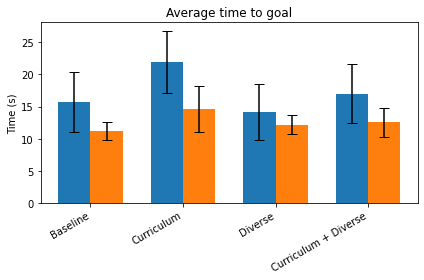

Method order: [(), ('curr',), ('div',), ('curr', 'div')]
Labels: ['Baseline', 'Curriculum', 'Diverse', 'Curriculum + Diverse']



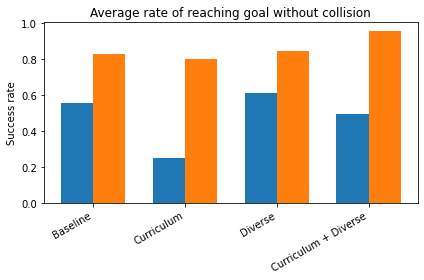

Method order: [(), ('curr',), ('div',), ('curr', 'div')]
Labels: ['Baseline', 'Curriculum', 'Diverse', 'Curriculum + Diverse']



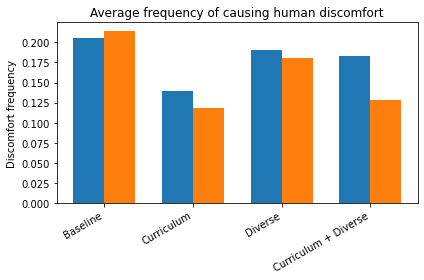

Method order: [(), ('curr',), ('div',), ('curr', 'div')]
Labels: ['Baseline', 'Curriculum', 'Diverse', 'Curriculum + Diverse']



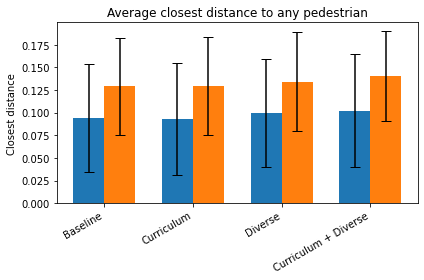

In [29]:
def res_plot(df, metric, std=None):
    """
    Produces bar plot of results over all (policy + training method) setups, for a given metric.
    
    Arguments:
    df (pd.DataFrame): df with averaged result values 
    metric (str): metric to be plotted; must be one of the column names 
    std (str): standard deviation of metric; must be one of the column names 
    """
    
    # Labels according to 
    title_dict = {
        'time': 'Average time to goal',
        'succ': 'Average rate of reaching goal without collision',
        'coll': 'Average collision rate',
        'rew': 'Average reward',
        'disc_freq': 'Average frequency of causing human discomfort',
        'danger_d_min': 'Average closest distance to any pedestrian'
        
    }
    y_dict = {
        'time': 'Time (s)',
        'succ': 'Success rate',
        'coll': 'Collision Rate',
        'rew': 'Reward',
        'disc_freq': 'Discomfort frequency',
        'danger_d_min': 'Closest distance'
        
    }
    assert metric in df.columns
    
    lstm  = df[(df.Policy == 'lstm') ]
    cadrl = df[(df.Policy == 'cadrl')]
    sarl  = df[(df.Policy == 'sarl') ]
    
    # make sure order is the same
    assert lstm['Methods'].tolist() == cadrl['Methods'].tolist() and cadrl['Methods'].tolist() == sarl['Methods'].tolist(), \
        f'Methods are not in same order between lstm, cadrl, and sarl'
    
    labels = ['Baseline', 'Curriculum', 'Diverse', 'Curriculum + Diverse']
    print(f"Method order: {lstm['Methods'].tolist()}")
    print(f"Labels: {labels}\n")
    
    if std:
        assert std in df.columns and std in ['std_time', 'std_rew', 'std_danger'] and metric in ['time', 'rew', 'danger_d_min']
        err_lstm  = lstm[std].tolist()
        err_cadrl = cadrl[std].tolist()
        err_sarl  = sarl[std].tolist()
        cap = 5
    else:
        err_lstm  = None
        err_cadrl = None
        err_sarl  = None
        cap = None
    

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars; .25 if 3 models, .35 if 2 models

    fig, ax = plt.subplots()
#     ax.bar(x - 1*width, lstm[metric],  width, label='LSTM_RL', yerr=err_lstm,  capsize=cap)
#     ax.bar(x + 0*width, cadrl[metric], width, label='CADRL',   yerr=err_cadrl, capsize=cap)
#     ax.bar(x + 1*width, sarl[metric],  width, label='SARL',    yerr=err_sarl,  capsize=cap)

    ax.bar(x - 0.5*width, lstm[metric],  width, label='LSTM_RL', yerr=err_lstm,  capsize=cap)
    #ax.bar(x + 0*width, cadrl[metric], width, label='CADRL',   yerr=err_cadrl, capsize=cap)
    ax.bar(x + 0.5*width, sarl[metric],  width, label='SARL',    yerr=err_sarl,  capsize=cap)

    #rects1 = ax.bar(x - width/2, men_means, width, label='SARL', yerr=[1]*5, capsize=8)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    assert metric in y_dict.keys()
    ax.set_ylabel(y_dict[metric])
    ax.set_title(title_dict[metric])
    ax.set_xticks(x, labels, rotation=30, ha='right')
    #ax.legend(bbox_to_anchor=(1, 1)) # make legend appear outside of plot

    #numbers on top
    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.savefig(f'figs/{metric}.png', dpi=400, pad_inches=2)
    plt.show()
    
res_plot(avgs_by_training, "time", "std_time")
res_plot(avgs_by_training, "succ")
res_plot(avgs_by_training, "disc_freq")
res_plot(avgs_by_training, "danger_d_min", "std_danger")

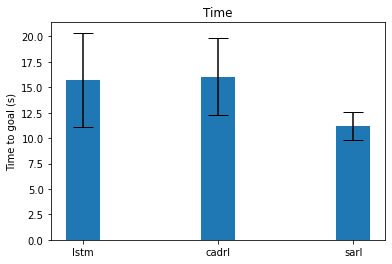

In [187]:
# Create lists for the plot

x_pos = np.arange(len(default['time']))

# Build the plot
fig, ax = plt.subplots()

#ax.bar(x_pos, default['time'], yerr=default['std_time'], align='center', capsize=10)
ax.bar(x_pos, default['time'], yerr=default['std_time'], capsize=10, width = 0.25)
# ax.bar(X + 0.00, data[0], width = 0.25)
ax.set_ylabel('Time to goal (s)')
ax.set_xticks(x_pos)
ax.set_xticklabels(default['Policy'])
ax.set_title('Time')
#ax.yaxis.grid(True)

# Save the figure and show
#plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


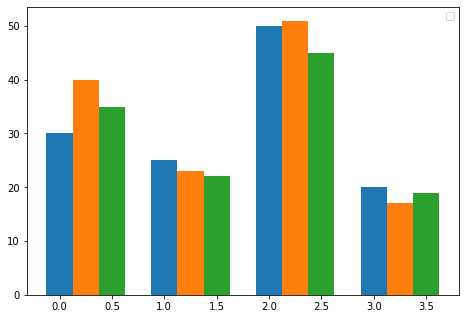

In [59]:
data = [[30, 25, 50, 20],
[40, 23, 51, 17],
[35, 22, 45, 19]]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['a', 'b', 'c', 'd']


# ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.00, data[0], width = 0.25)
ax.bar(X + 0.25, data[1], width = 0.25)
ax.bar(X + 0.50, data[2], width = 0.25)

ax.set_xticks(X, labels)
ax.legend()
